# ES335 Assignment 1: Task 1

## Imports

In [2]:
import os
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.decomposition import PCA
import numpy as np

## Utility functions

In [3]:
activity_classes = ["LAYING", "SITTING", "STANDING", "WALKING", "WALKING_DOWNSTAIRS", "WALKING_UPSTAIRS"]

def get_sample_data(path):
	sample_data = []
	for activity_class in activity_classes:
		subpath = os.path.join(path, activity_class)
		files = os.listdir(subpath)
		sample_data.append(os.path.join(subpath, files[0]))
	return sample_data

def load_csv_files(directory, label):
    df_list = []

    for filename in os.listdir(directory):
        if filename.endswith('.csv'):
            file_path = os.path.join(directory, filename)
            df = pd.read_csv(file_path)
            df['Subject'] = filename.replace('.csv', '')
            df_list.append(df)

    combined_df = pd.concat(df_list, ignore_index=True)
    combined_df['y'] = label
    return combined_df

def prepare_dataset(path):
    train_path = os.path.join(path, "Train")
    test_path = os.path.join(path, "Test")
    
    train_dfs = pd.concat([load_csv_files(os.path.join(train_path, activity_class), label) for label, activity_class in enumerate(activity_classes)])
    test_dfs = pd.concat([load_csv_files(os.path.join(test_path, activity_class), label) for label, activity_class in enumerate(activity_classes)])
    
    return train_dfs, test_dfs

## Solutions

### 1. Plot the waveform for one sample data from each activity class. Are you able to see any difference/similarities between the activities? You can plot a subplot having 6 columns to show differences/similarities between the activities. Do you think the model will be able to classify the activities based on the data? [0.5 marks]

In [4]:
sample_data = get_sample_data(os.path.join('Combined', 'Train'))

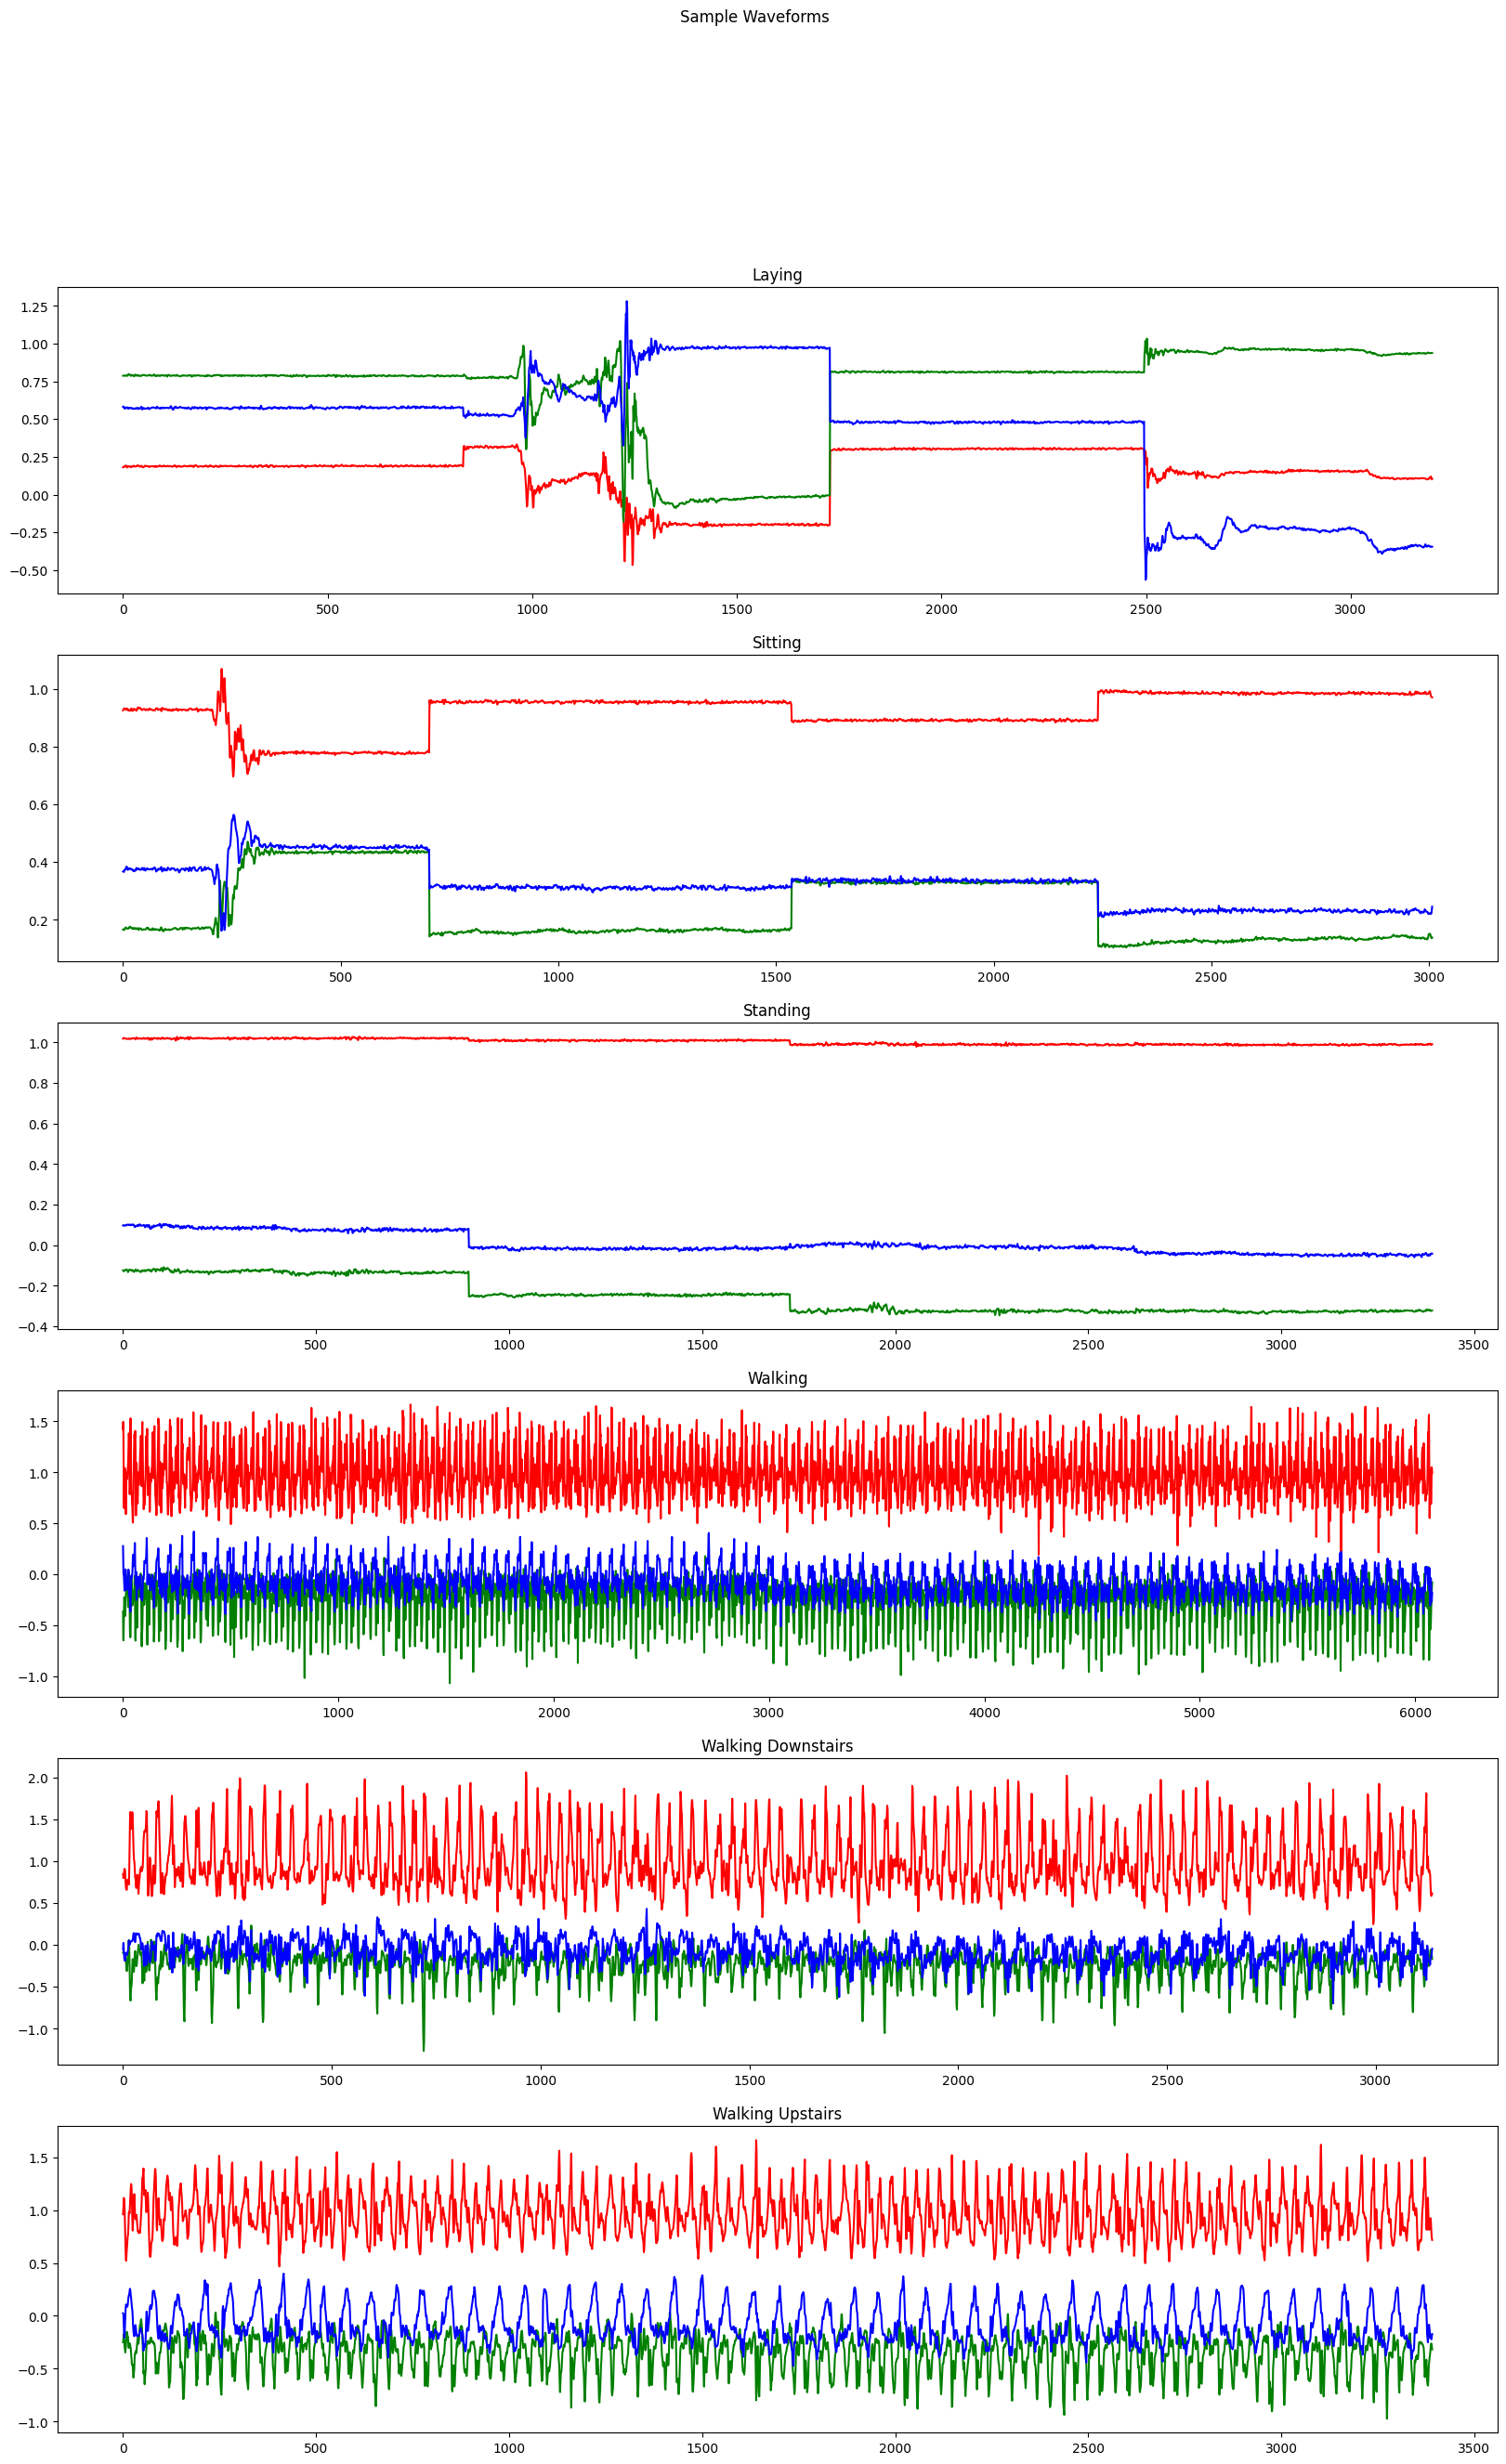

In [5]:
fig, (ax1, ax2, ax3, ax4, ax5, ax6) = plt.subplots(6, 1, figsize=(20, 30))
fig.suptitle('Sample Waveforms')
titles = [sample.split('\\')[2].title().replace('_', ' ') for sample in sample_data]

dfs = [pd.read_csv(sample_data[i]) for i in range(6)]

for i, ax in enumerate((ax1, ax2, ax3, ax4, ax5, ax6)):
    ax.set_title(titles[i])
    ax.plot(dfs[i]['accx'], color='r')
    ax.plot(dfs[i]['accy'], color='g')
    ax.plot(dfs[i]['accz'], color='b')

Yes, the model will be able to classify the activities based on the data. 

### 2. Do you think we need a machine learning model to differentiate between static activities (laying, sitting, standing) and dynamic activities(walking, walking_downstairs, walking_upstairs)? Look at the linear acceleration $(acc_x^2 + acc_y^2 + acc_z^2)$ for each activity and justify your answer.


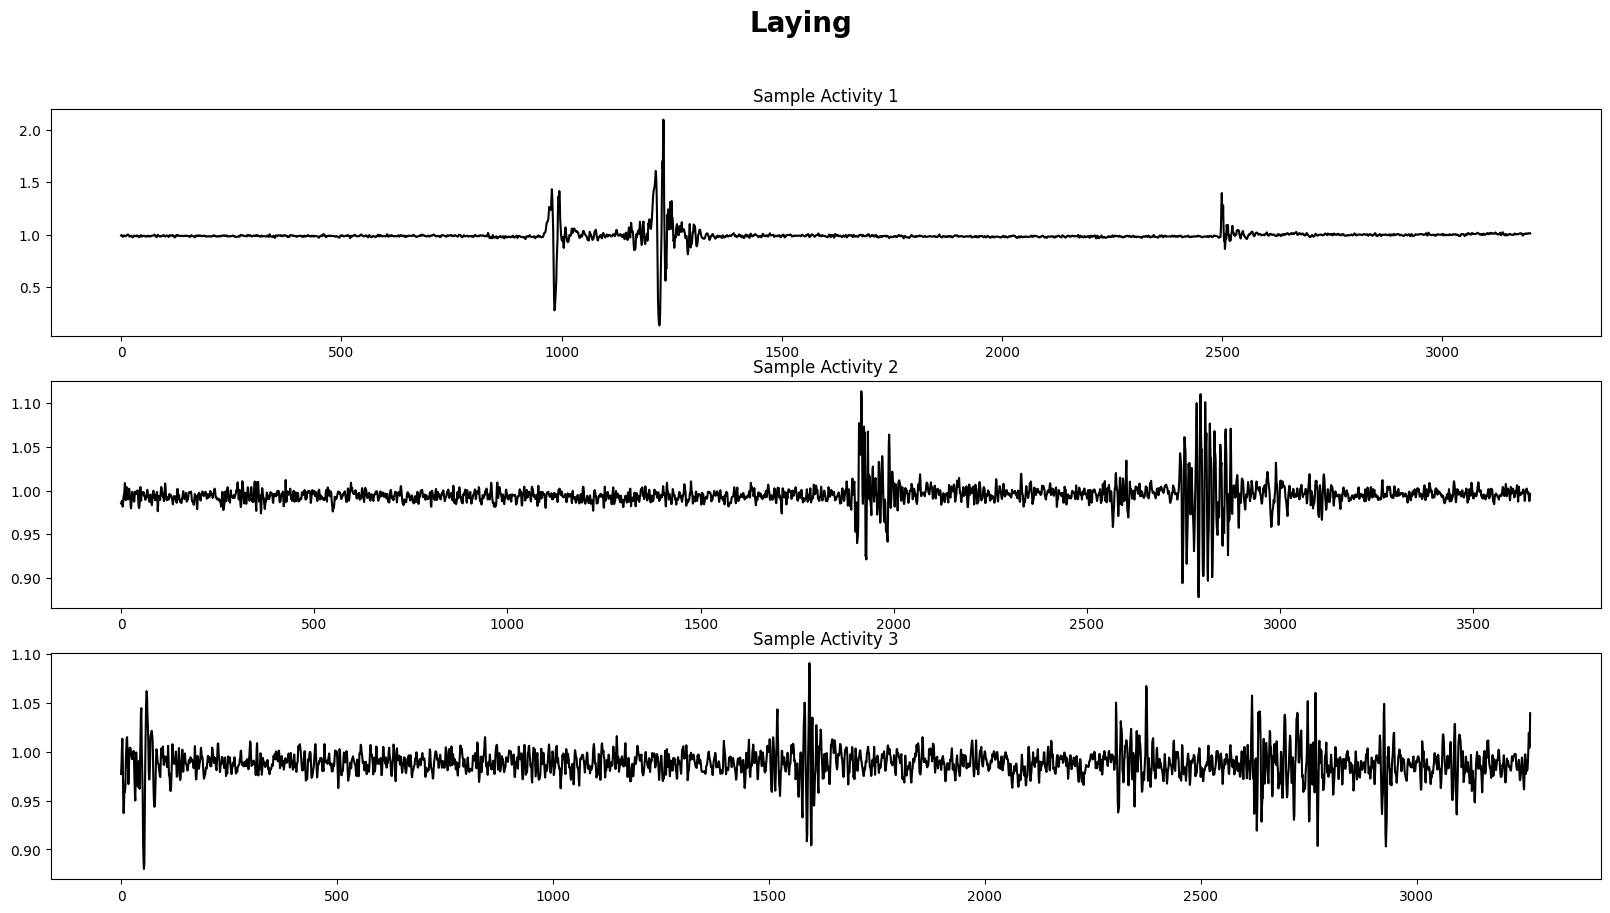

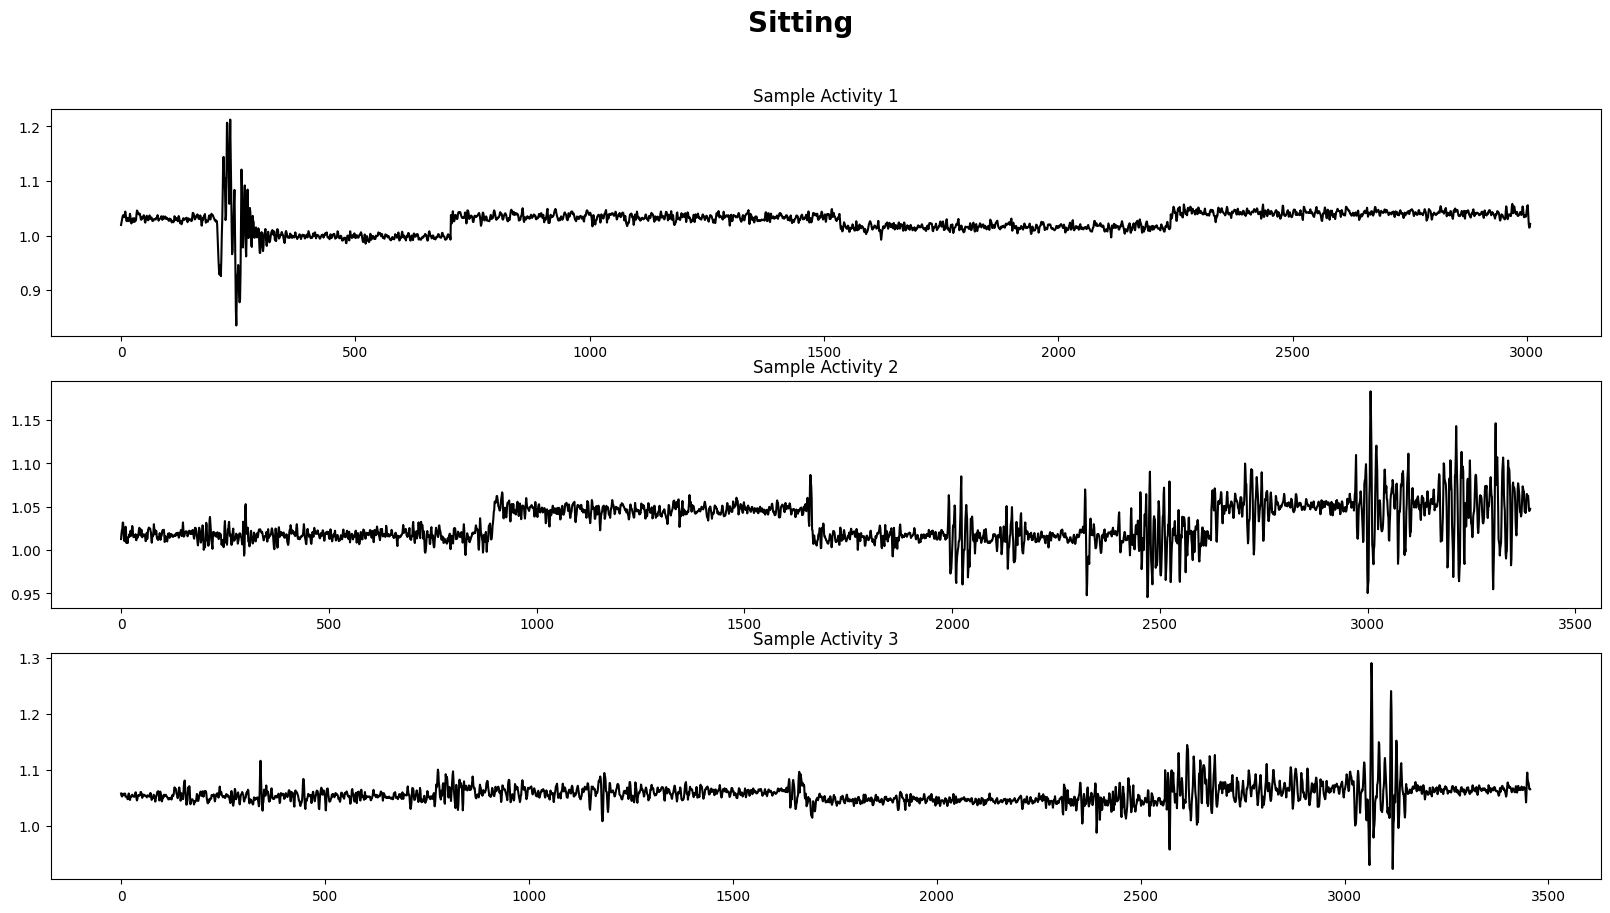

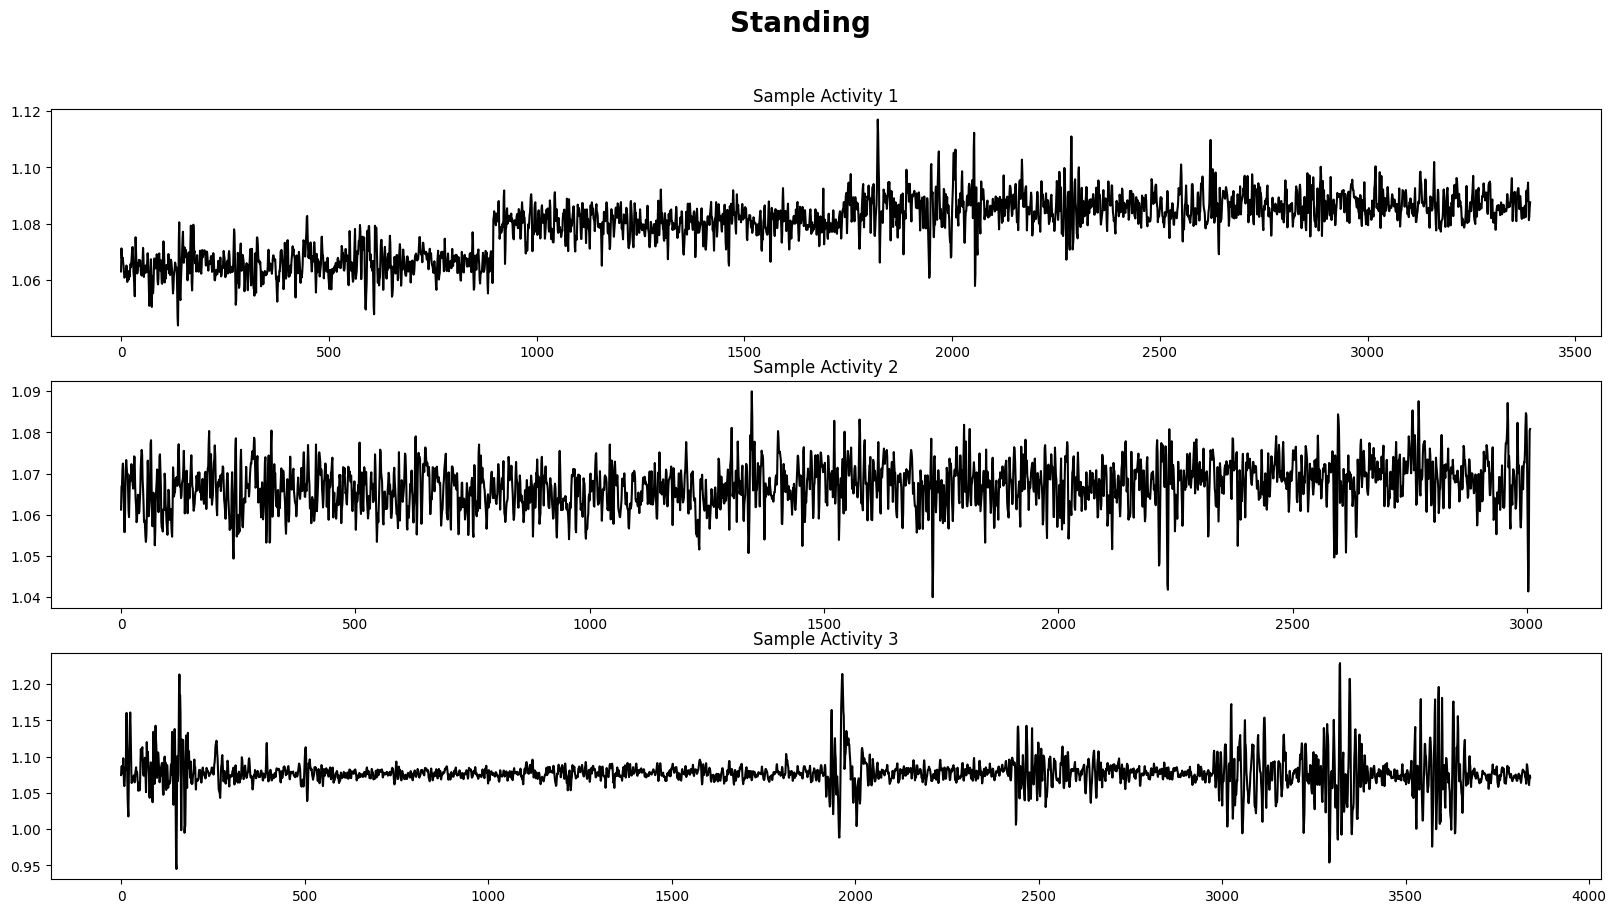

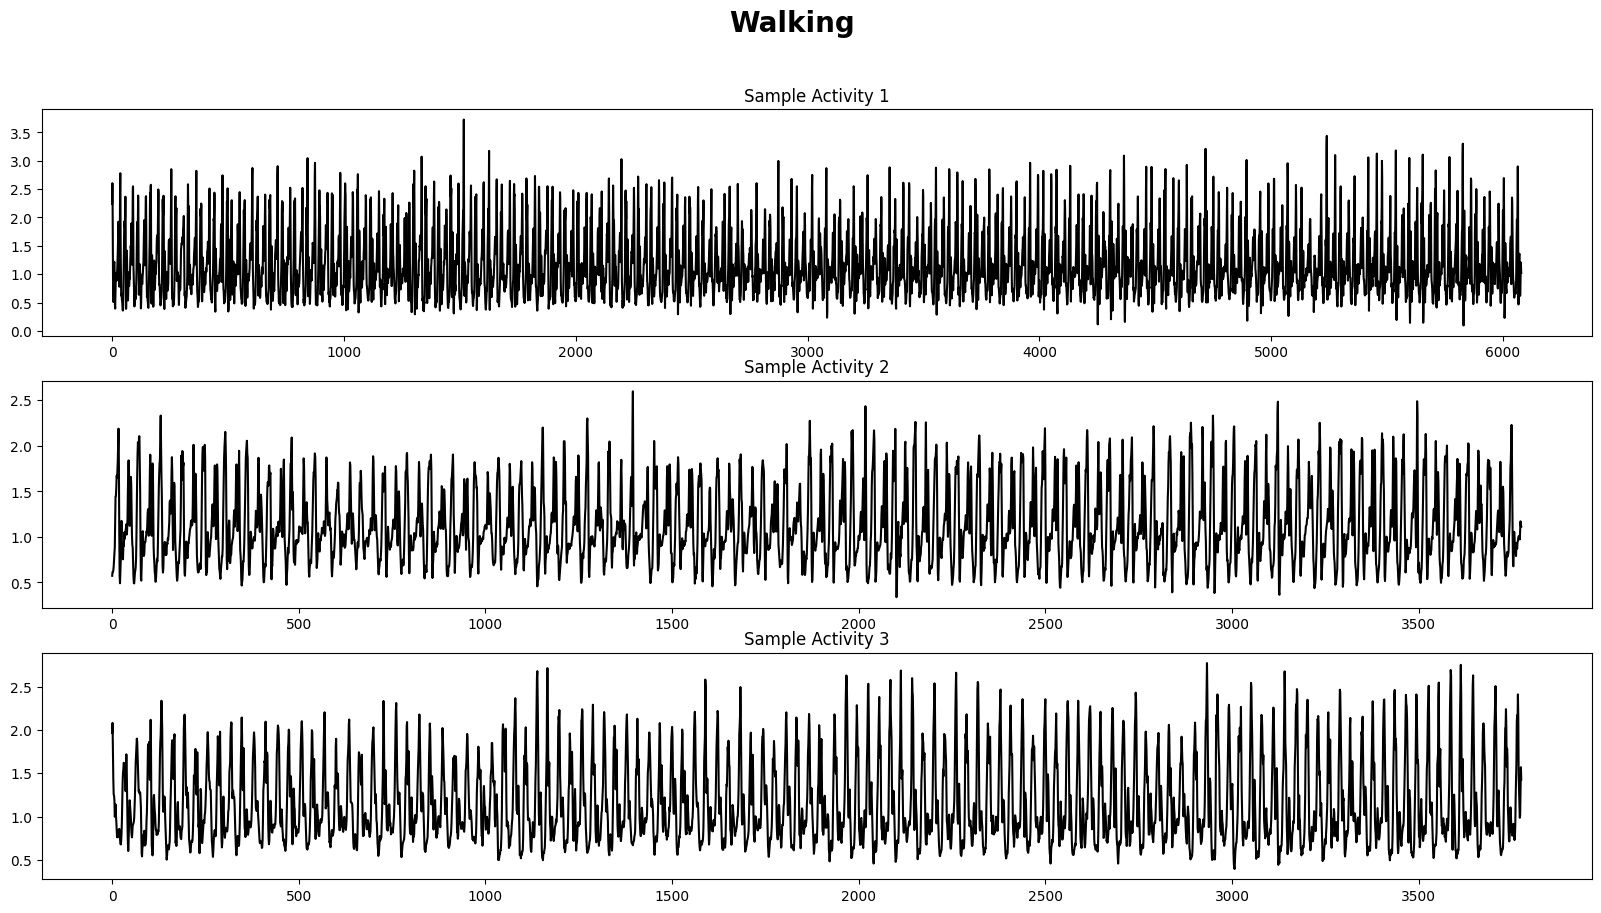

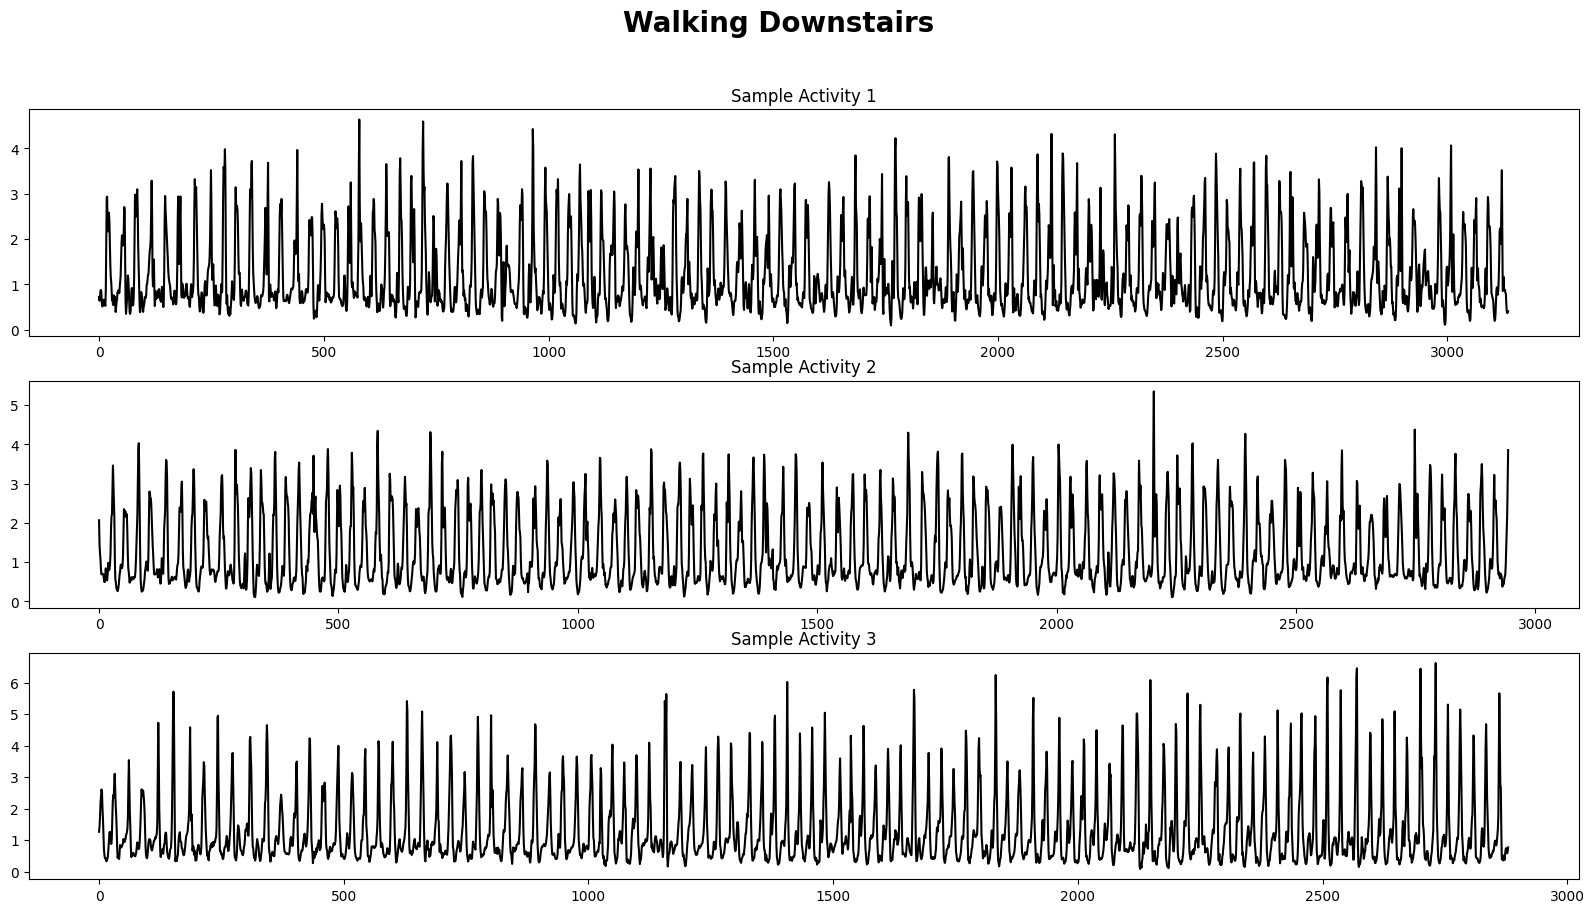

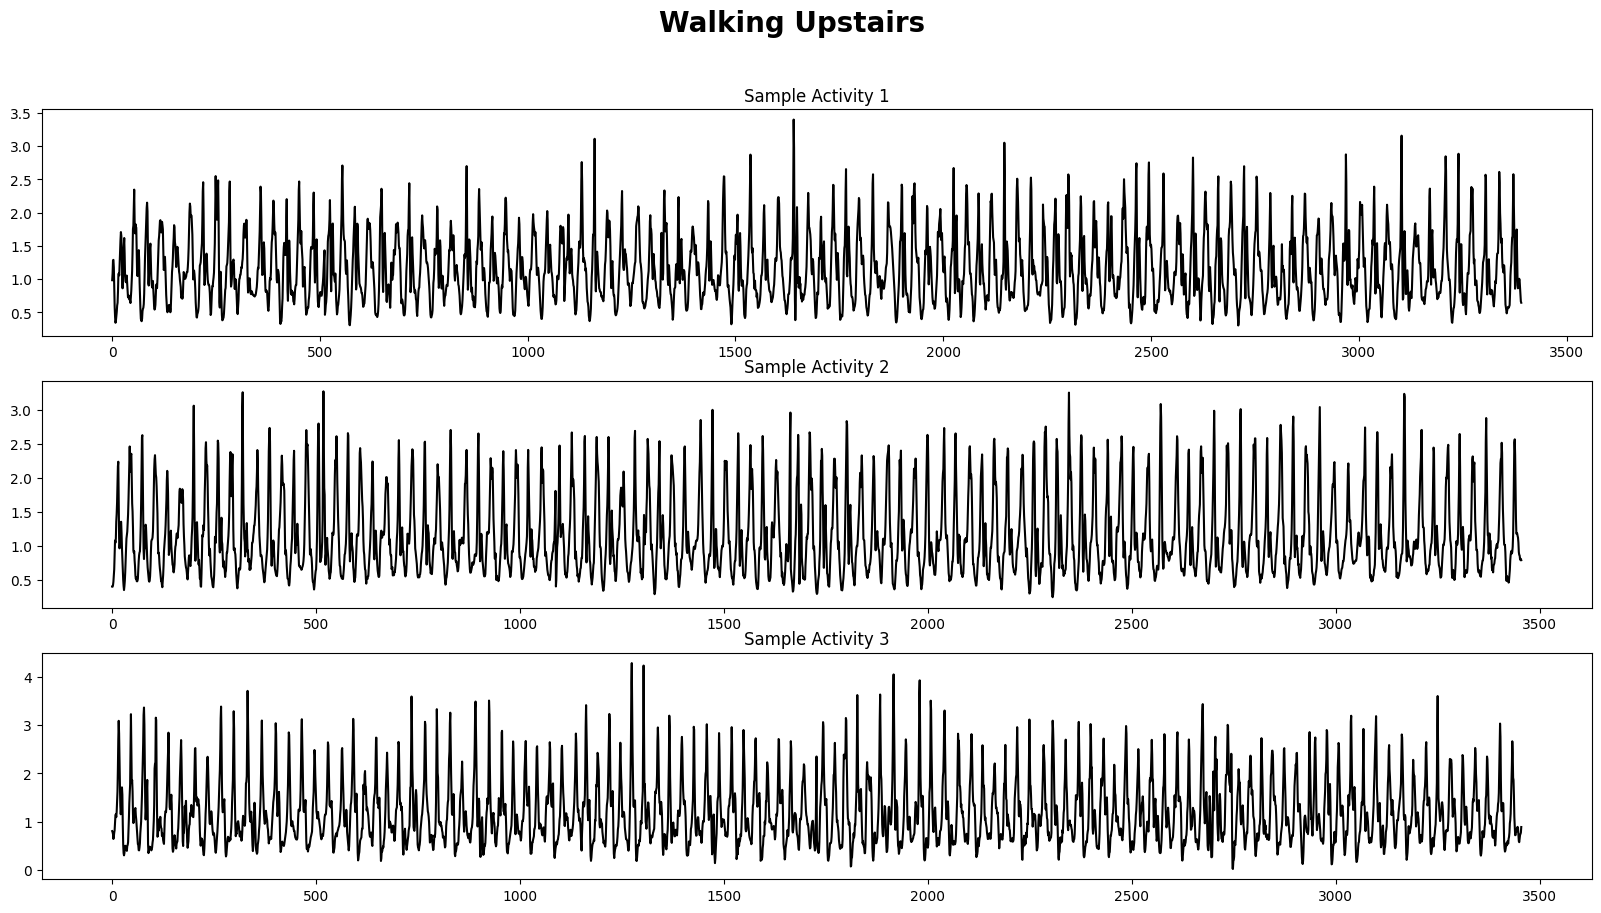

In [6]:
sample_data = []

for activity_class in activity_classes:
    subpath = os.path.join(os.path.join("Combined", "Train"), activity_class)
    files = os.listdir(subpath)
    for j in range(3):
        sample_data.append(os.path.join(subpath, files[j]))

dfs = [pd.read_csv(sample_data[i]) for i in range(18)]

linear_accelerations = [dfs[i]['accx'] * dfs[i]['accx'] + dfs[i]['accy'] * dfs[i]['accy'] + dfs[i]['accz'] * dfs[i]['accz'] for i in range(18)]

fig, ax = [], []
for i in range(6):
    fig_, ax_ = plt.subplots(3, 1, figsize=(20, 10))
    fig.append(fig_)
    ax.append(ax_)

for i, (fig_, ax_) in enumerate(zip(fig, ax)):
    fig_.suptitle(titles[i], fontsize=20, fontweight='heavy')
    for j in range(3):
        ax_[j].set_title(f'Sample Activity {j + 1}')
        ax_[j].plot(linear_accelerations[3 * i + j], color='black')


For classifying static activities, machine learning models might be unnecessary because linear acceleration plots can often be visually inspected to distinguish between different activities. However, for dynamic activities such as walking, a machine learning model is more appropriate. This is because dynamic activities do not have straightforward visual cues that clearly reveal the activity being performed, making it difficult to classify based on visual inspection alone.

### 3. Visualize the data using PCA.

In [7]:
train, test = prepare_dataset("Combined")

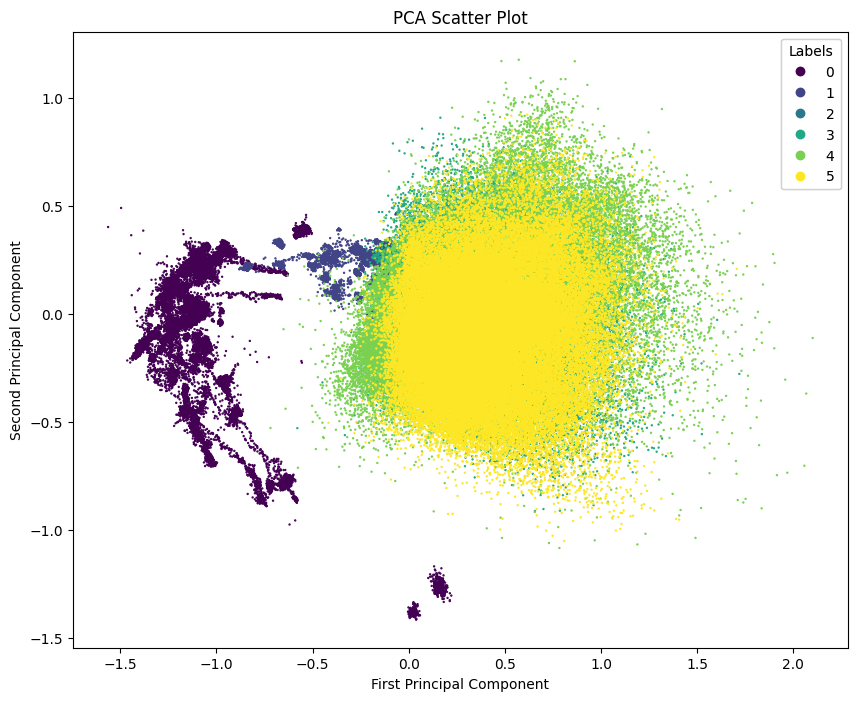

In [14]:
def plot_pca(x: np.ndarray, y: np.ndarray, components=2):
    pca = PCA(n_components=components).fit_transform(x)
        
    plt.figure(figsize=(10, 8))
    scatter = plt.scatter(pca[:, 0], pca[:, 1], c=y, cmap='viridis', s=0.5)
    plt.gca().add_artist(plt.legend(*scatter.legend_elements(), loc="upper right", title="Labels"))
    plt.xlabel(f'First Principal Component')
    plt.ylabel(f'Second Principal Component')
    plt.title('PCA Scatter Plot')
    plt.show()

def plot_pca_acceleration(data: pd.DataFrame):
	x = data[['accx', 'accy', 'accz']].to_numpy()
	y = data['y'].to_numpy()
	plot_pca(x, y, 2)

plot_pca_acceleration(train)